# Still in progress!

Idea is to compare measurements from

1) Baseline SLICS
2) Slics decomposed in 4 subfields
3) Masked SLICS
4) Masked + inpainted SLICS

In [2]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

In [11]:
catname = "GalCatalog_LOS1.fits"
path_to_SLICS = "http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/" + catname
savepath_SLICS = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/"
nbinsz = 3
nthreads = 48

frac_covs = [0.,0,]

In [ ]:
!wget {path_to_SLICS} -P {savepath_SLICS}

In [4]:
slicscat = Table.read(savepath_SLICS + catname)
print(slicscat.keys())

['x_arcmin', 'y_arcmin', 'z_spectroscopic', 'z_photometric', 'shear1', 'shear2', 'eps_obs1', 'eps_obs2']


In [8]:
# Basic catalog
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"],
                                     pos2=slicscat["y_arcmin"],
                                     tracer_1=slicscat["shear1"],
                                     tracer_2=slicscat["shear2"])
shapecat.create_mask(method="Basic", pixsize=0.3)

In [10]:
# Masked cat
isinner_cut = np.ones_like(shapecat.isinner)
isinner_cut[slicscat["x_arcmin"]<90] = 0.
isinner_cut[slicscat["y_arcmin"]<90] = 0.
isinner_cut[slicscat["x_arcmin"]>510] = 0.
isinner_cut[slicscat["y_arcmin"]>510] = 0.
shapecat_cut = orpheus.SpinTracerCatalog(spin=2,
                                         pos1=slicscat["x_arcmin"],
                                         pos2=slicscat["y_arcmin"],
                                         tracer_1=slicscat["shear1"],
                                         tracer_2=slicscat["shear2"],
                                         isinner=isinner_cut)
shapecat_cut.create_mask(method="Basic", pixsize=0.3)

In [25]:
Rmin = 1.
Rmax = 64.
nbinsr = 14
frac_covs=[0.0, 0.1, 0.3, 0.5, 1.0]
order_max = 6

In [26]:
%%time
direct = orpheus.Direct_MapnEqual(order_max=order_max, Rmin=Rmin, Rmax=Rmax, nbinsr=nbinsr, nthreads=nthreads, 
                                  filter_form="C02", frac_covs=frac_covs, accuracies=1.)
direct_noov = orpheus.Direct_MapnEqual(order_max=order_max, Rmin=Rmin, Rmax=Rmax, nbinsr=nbinsr, nthreads=nthreads, 
                                       filter_form="C02", frac_covs=frac_covs, weight_outer=0., accuracies=1.)
direct_ov = orpheus.Direct_MapnEqual(order_max=order_max, Rmin=Rmin, Rmax=Rmax, nbinsr=nbinsr, nthreads=nthreads, 
                                     filter_form="C02", frac_covs=frac_covs, weight_outer=1., accuracies=1.)
mapn, mapn_ws = direct.process(shapecat_cut,dotomo=True)
mapn_noov, mapn_noov_ws = direct_noov.process(shapecat_cut,dotomo=True)
mapn_ov, mapn_ov_ws = direct_ov.process(shapecat_cut,dotomo=True)

Done 14/14 aperture radiiCPU times: user 7min 56s, sys: 1.91 s, total: 7min 58s
Wall time: 20.6 s


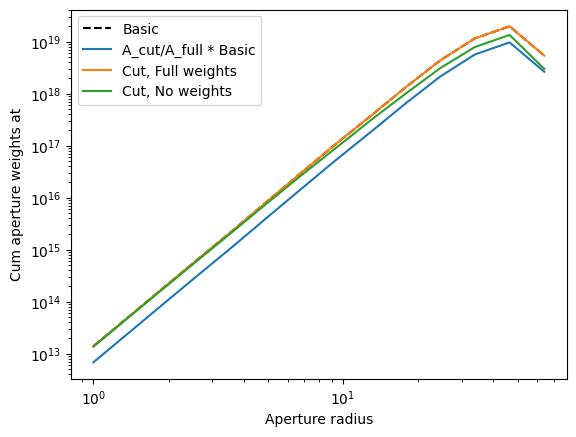

In [28]:
plt.loglog(direct_ov.radii,-mapn_ws[:,0,2],'k--',label='Basic')
plt.semilogy(direct_ov.radii,-(10.-3.)**2/100.*mapn_ws[:,0,2],label='A_cut/A_full * Basic')
plt.semilogy(direct_ov.radii,-mapn_ov_ws[:,0,2],label='Cut, Full weights')
plt.semilogy(direct_ov.radii,-mapn_noov_ws[:,0,2],label='Cut, No weights')
plt.xlabel('Aperture radius')
plt.ylabel('Cum aperture weights at')
plt.legend()